In [20]:
from mnist_gan.mnistGan import MnistGan
from mnist_cnn.mnistCnn import MnistCnn
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.nn import conv2d

In [43]:
cnn = MnistCnn()
cnn.loadWeights('mnist_cnn/largerCnn30Epochs')

(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]
print(img_data.shape)
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255
print(test_data.shape)
y_test_one_hot = np.eye(10)[y_test]
print(y_test_one_hot.shape)
print(y_test_one_hot[0:2])

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 10)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [22]:
print()

In [23]:
# test the cnn
test_results = cnn.model.evaluate(test_data, y_test_one_hot)
print("test loss, test acc: ", test_results)

313/313 [==============================] - 1s 1ms/step - loss: 0.0207 - accuracy: 0.9950
test loss, test acc:  [0.020660927519202232, 0.9950000047683716]


In [24]:
# Unglaette, sum of differences between pixels, horizontally and vertically (not diagonally)
def computeU(img):
    kernel1 = np.array([[-1,1]], np.float32)
    kernel1 = np.expand_dims(kernel1, -1)
    kernel1 = np.expand_dims(kernel1, -1)
    kernel2 = np.array([[-1],[1]], np.float32)
    kernel2 = np.expand_dims(kernel2, -1)
    kernel2 = np.expand_dims(kernel2, -1)
    horizU = conv2d(img, kernel1, strides = (1,1,1,1), padding = 'VALID')
    vertU = conv2d(img, kernel2, strides = (1,1,1,1), padding = 'VALID')
    horizU = tf.abs(horizU)
    vertU = tf.abs(vertU)
    hSum = tf.reduce_sum(horizU)
    vSum = tf.reduce_sum(vertU)
    return hSum + vSum

In [25]:
# total whitespaces of the image, sum of pixel values
def computeS(img):
    return np.sum(img)

In [26]:
#test U
test_img = np.expand_dims(img_data[0],0)
print(test_img.shape)
u_example = computeU(test_img).numpy()
print(u_example)

(1, 28, 28, 1)
112.21960784313725


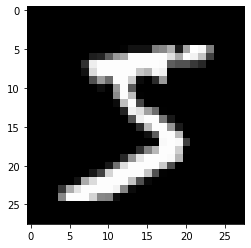

In [27]:
plt.imshow(test_img[0,:,:,0], cmap = 'gray')

In [28]:
#test S
s_example = computeS(test_img)
print(s_example)

107.94117647058823


In [29]:
dim = img_data.shape[0]
print(dim)
unglaette = np.zeros([dim], np.float32)
whitespaces = np.zeros([dim], np.float32)
for i in range(dim):
    img = np.expand_dims(img_data[i],0)
    whitespaces[i] = computeS(img)
    unglaette[i] = computeU(img).numpy()
print(whitespaces[0:10])
print(unglaette[0:10])

60000
[107.94118  121.94118   76.247055  67.196075  91.03529  116.08235
  69.2      140.6549    42.64314   85.89804 ]
[112.219604 122.8       95.8353    64.44706  103.34118  125.39608
  52.933334 113.07451   47.513725 103.11372 ]


/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


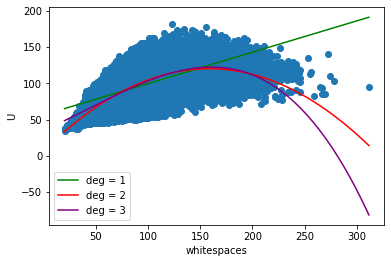

In [30]:
plt.scatter(x = whitespaces, y = unglaette)
plt.xlabel('whitespaces')
plt.ylabel('U')

p1 = np.poly1d(np.polyfit(whitespaces, unglaette, 1))
p2 = np.poly1d(np.polyfit(whitespaces, unglaette, 2))
p3 = np.poly1d(np.polyfit(whitespaces, unglaette, 3))

pLine = np.linspace(np.min(whitespaces), np.max(whitespaces), 50, dtype = np.float32)

plt.plot(pLine, p1(pLine), color = 'green')
plt.plot(pLine, p2(pLine), color = 'red')
plt.plot(pLine, p3(pLine), color = 'purple')

plt.legend(['deg = 1', 'deg = 2', 'deg = 3'])

plt.show()

In [31]:
# coefficients
p1_coeffs = p1.c.tolist()
p2_coeffs = p2.c.tolist()
p3_coeffs = p3.c.tolist()

In [32]:
# compute the polynomial p(s) thats defined by the given coeffs for an img
def computeU_dash(coeffs, img):
    return tf.math.polyval(coeffs, tf.math.reduce_sum(img))

In [33]:
# test U_dash
x_test = tf.Variable(tf.cast(test_img, tf.float32))
u_dash_example = computeU_dash(p3_coeffs, x_test).numpy()
print(u_dash_example)

107.62456


In [34]:
# target function
@tf.function
def g1(x, index, classifier):
    # minimize p and u
    #p = tf.math.log(tf.squeeze(classifier(x)[index]))
    #print(p)
    res = tf.math.log(tf.squeeze(classifier(x))[index]) + computeU(x)
    return res

In [35]:
# target function 2
@tf.function
def g2(x, index, classifier):
    # minimize p and (u - u_dash)
    res = tf.math.log(tf.squeeze(classifier(x))[index]) + (computeU(x) - computeU_dash(p3_coeffs, x))
    return res

In [36]:
# target function 3
@tf.function
def g3(x, index, classifier):
    # minimize p and -u_dash
    res = tf.math.log(tf.squeeze(classifier(x))[index]) - computeU_dash(p3_coeffs, x)
    return res

In [37]:
def explain(x, classifier, maxIter, maxChange, minAlpha, target_function = g1):
    epsilon = 1e-16 #accuracy
    closeEnough = False
    iter = 0 #iteration count
    index = tf.argmax(tf.squeeze(classifier(x))).numpy() #original prediction
    
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
            res = target_function(x, index, classifier)
        grad = tape.gradient(res, x)
        max_grad = tf.abs(tf.reduce_max(grad))
        alpha = tf.minimum(minAlpha, maxChange/tf.maximum(max_grad, epsilon))
        x.assign(x - alpha * grad)
        x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        newIndex = tf.argmax(tf.squeeze(classifier(x))).numpy()
        if ((newIndex != index)): # done when the prediction has changed
            closeEnough = True
    print("done after ", iter, " steps")

done after  225  steps
done after  205  steps
done after  600  steps
0.8183112 0.20197403
done after  157  steps
done after  117  steps
done after  600  steps
0.8049398 0.23806947
done after  138  steps
done after  98  steps
done after  600  steps
0.70506203 0.2512499
done after  122  steps
done after  72  steps
done after  600  steps
0.70615506 0.24017376
done after  194  steps
done after  150  steps
done after  600  steps
0.8008137 0.19633469


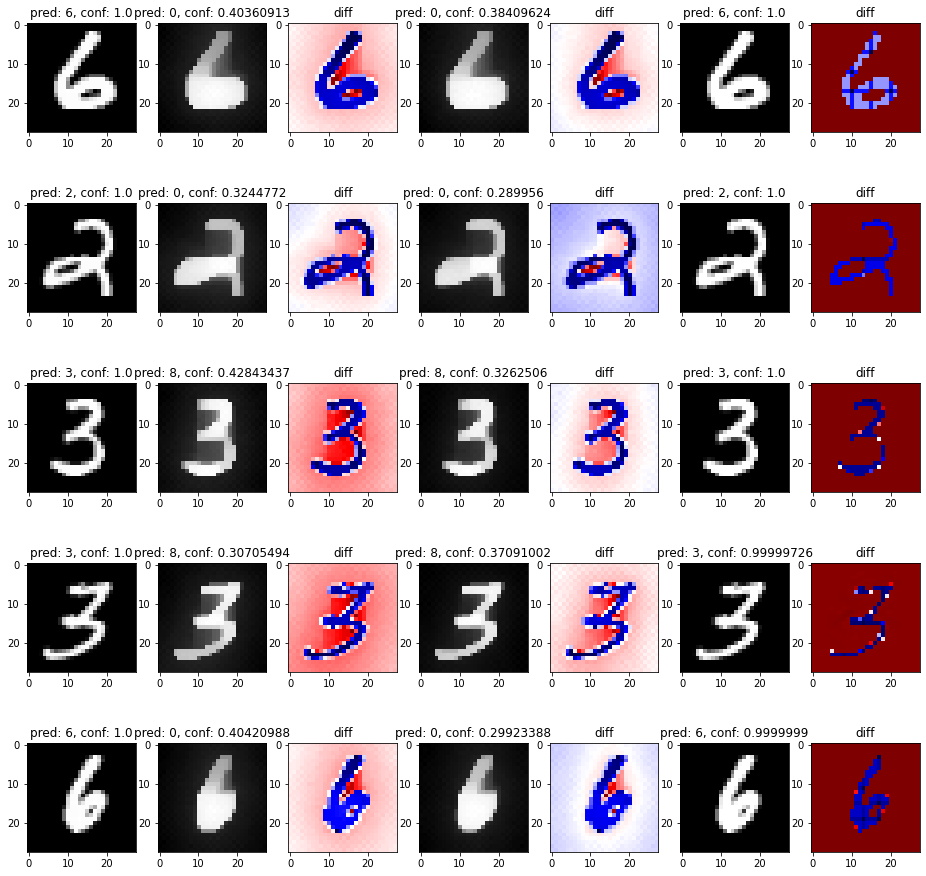

In [44]:
# select n images randomly
n_examples = 5
indices = np.random.randint(0, img_data.shape[0], n_examples)

_, ax = plt.subplots(n_examples, 7, figsize = (16, 16))

for i in range(len(indices)):
    img = img_data[indices[i]]
    x1 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
    x2 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
    x3 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
    explain(x1, cnn.model, 600, 0.0099, 1, target_function = g1) #p+u
    explain(x2, cnn.model, 600, 0.0099, 1, target_function = g2) #p+(u-u_dash)
    explain(x3, cnn.model, 600, 0.0099, 1, target_function = g3) #p-u_dash
    # plot the original image
    ax[i, 0].imshow(img, cmap = 'gray')
    pred0 = tf.squeeze(cnn.model(np.expand_dims(img, 0)))
    conf0 = tf.reduce_max(pred0).numpy()
    class0 = tf.argmax(pred0).numpy()
    title0 = "pred: " + str(class0) + ", conf: " + str(conf0)
    ax[i, 0].set_title(title0)
    # plot p+u
    ax[i, 1].imshow(x1[0], cmap = 'gray')
    pred1 = tf.squeeze(cnn.model(x1))
    conf1 = tf.reduce_max(pred1).numpy()
    class1 = tf.argmax(pred1).numpy()
    title1 = "pred: " + str(class1) + ", conf: " + str(conf1)
    ax[i, 1].set_title(title1)
    # diff img
    diff_img1 = ((x1[0] - img)/2 + 0.5) # diff in range [-1,1], move back to [0,1]
    print(tf.reduce_max(diff_img1).numpy(), tf.reduce_min(diff_img1).numpy())
    ax[i, 2].imshow(diff_img1, cmap = 'seismic')
    ax[i, 2].set_title("diff")
    # plot p+(u-u_dash)
    ax[i, 3].imshow(x2[0], cmap = 'gray')
    pred2 = tf.squeeze(cnn.model(x2))
    conf2 = tf.reduce_max(pred2).numpy()
    class2 = tf.argmax(pred2).numpy()
    title2 = "pred: " + str(class2) + ", conf: " + str(conf2)
    ax[i, 3].set_title(title2)
    # diff img
    diff_img2 = ((x2[0] - img)/2 + 0.5) # diff in range [-1,1], move back to [0,1]
    ax[i, 4].imshow(diff_img2, cmap = 'seismic')
    ax[i, 4].set_title("diff")
    # plot p-u_dash
    ax[i, 5].imshow(x3[0], cmap = 'gray')
    pred3 = tf.squeeze(cnn.model(x3))
    conf3 = tf.reduce_max(pred3).numpy()
    class3 = tf.argmax(pred3).numpy()
    title3 = "pred: " + str(class3) + ", conf: " + str(conf3)
    ax[i, 5].set_title(title3)
    # diff img
    diff_img3 = ((x3[0] - img)/2 + 0.5) # diff in range [-1,1], move back to [0,1]
    ax[i, 6].imshow(diff_img3, cmap = 'seismic')
    ax[i, 6].set_title("diff")